Goal: We want to visualize the distributional shifts between MIMIC-III and MIMIC-IV 

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd

2024-12-06 11:12:12.615972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 11:12:12.616020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 11:12:12.617277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:12:12.624375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 11:12:13.376308: W tensorflow/compiler/tf2

In [2]:
def custom_train_reps(source_features, target_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    source_reps = source_pca.fit_transform(source_features)

    # Use source PCA to embed target representations (based on the assumption source and target are using the same ICD encoding system)
    target_reps = source_pca.fit_transform(target_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = source_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return source_reps, target_reps

In [8]:
def plot_pair(full_df, group_name, type, source, target, source_count, target_count, input_name, output_name, ax, n_components):
    """ 
    Plot pairwise embedding distributions between source (with source_count) and target (with target_count) on axis ax 
    """
    
    selected_df = select_samples(full_df, group_name, type, source, target, source_count=source_count, target_count=target_count)


    source_features, _, target_features, _ = gen_code_feature_label(selected_df, group_name, type, source, target, input_name, output_name)

    source_reps, target_reps = custom_train_reps(source_features, target_features, n_components)
    ax.scatter(source_reps[:, 0], source_reps[:, 1], label=source, s=1)
    ax.scatter(target_reps[:, 0], target_reps[:, 1], label=target, s=1)
    ax.legend(prop={'size': 6})


number of target indices is: 22582 target_count is: 500
number of source indices is: 611 source_count is: 500
number of codes is: 1806
number of target indices is: 1783 target_count is: 500
number of source indices is: 611 source_count is: 500
number of codes is: 1871
number of target indices is: 28215 target_count is: 500
number of source indices is: 611 source_count is: 500
number of codes is: 1871
number of target indices is: 5785 target_count is: 500
number of source indices is: 611 source_count is: 500
number of codes is: 1950
number of target indices is: 611 target_count is: 500
number of source indices is: 22582 source_count is: 500
number of codes is: 1854
number of target indices is: 1783 target_count is: 500
number of source indices is: 22582 source_count is: 500
number of codes is: 1894
number of target indices is: 28215 target_count is: 500
number of source indices is: 22582 source_count is: 500
number of codes is: 1828
number of target indices is: 5785 target_count is: 500

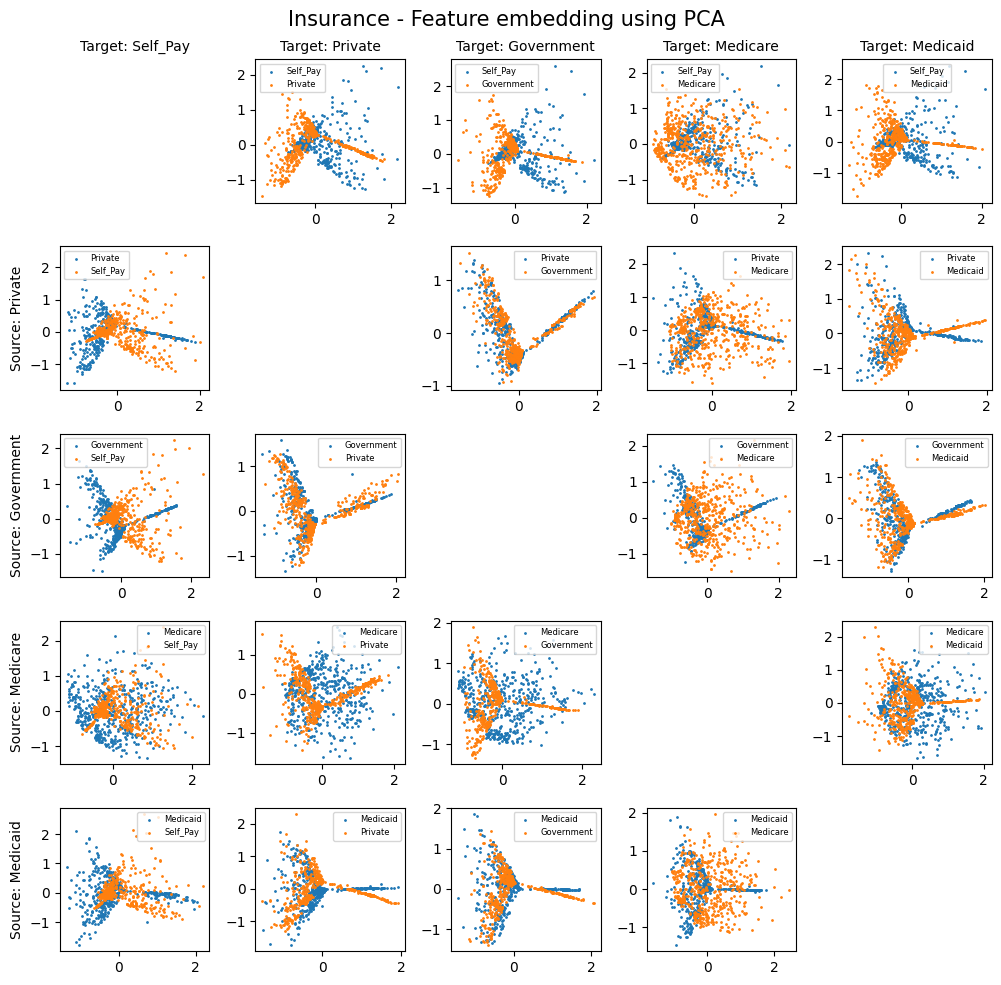

In [10]:
# Set parameters 
output_dir = mimic_output_dir
n_components = 50
source_count = 500
target_count = 500
type = 'cat'
input_name = 'ICD codes'
output_name = 'duration'
full_df = pd.read_csv(os.path.join(output_dir, "admission_patient_diagnosis_ICD.csv"), index_col=None, header=0, converters={'ICD codes': literal_eval})

group_name = 'insurance'
groups = ['Self_Pay', 'Private',  'Government', 'Medicare', 'Medicaid']

# group_name = 'marital_status'
# groups = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED']

# Plot pairwise plots 
fig, axs = plt.subplots(len(groups), len(groups))
fig.set_figwidth(10)
fig.set_figheight(10)

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if j == 0:
            axs[i, j].set_ylabel(f'Source: {group_1}', fontsize=10)
        if i == 0:
            axs[i, j].set_title(f'Target: {group_2}', fontsize=10)
        if group_1 == group_2:
            axs[i, j].axis('off')
            continue

        plot_pair(full_df, group_name, type, group_1, group_2, \
                  source_count, target_count, input_name, output_name, axs[i,j], n_components)

fig.suptitle(f"Insurance - Feature embedding using PCA", fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{group_name}_distn_shift.pdf"))
